# Overview
This notebook test the perfomances of OCT2Hist model end to end on a reference dataset described oin [our paper](https://www.medrxiv.org/content/10.1101/2021.03.31.21254733v1).

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/OCT2Hist-ModelInference/blob/main/cropping_analysis.ipynb) and run.

## Notebook's Inputs:

In [1]:
# Pre-processed dataset
preprocessed_dataset_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/"

# Define input images
preprocessed_oct_image_paths = [
 (preprocessed_dataset_path + "LE-03-Slide04_Section01_yp0_patch01_real_A.png"), # Used in Paper Figure 3.b
 (preprocessed_dataset_path + "LG-19-Slide04_Section02_yp0_patch01_real_A.png"), # Used in Paper Figure 3.c
 (preprocessed_dataset_path + "LF-01-Slide04_Section02_yp0_patch01_real_A.png"), # Used in Paper Figure 3.d
 (preprocessed_dataset_path + "LG-44-Slide05_Section03_yp0_patch01_real_A.png"), # Used in Paper Figure 3.e
]

# Raw images dataset
raw_dataset_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Raw Data Used In Paper (Paper V2)/"

# Define input images
raw_dataset_path_oct_image_paths = [
 (raw_dataset_path + "LE-03 - Slide04_Section01 (Fig 3.b)/OCTAligned.tiff"), # Used in Paper Figure 3.b
 (raw_dataset_path + "LG-19 - Slide04_Section02 (Fig 3.c)/OCTAligned.tiff"), # Used in Paper Figure 3.c
 (raw_dataset_path + "LF-01 - Slide04_Section02 (Fig 3.d)/OCTAligned.tiff"), # Used in Paper Figure 3.d
 (raw_dataset_path + "LG-44 - Slide05_Section03 (Fig 3.e)/OCTAligned.tiff"), # Used in Paper Figure 3.e
]

## Set Up Environment

In [2]:
!git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-ModelInference
%cd OCT2Hist-ModelInference

import cv2
import matplotlib.pyplot as plt
import numpy as np
import oct2hist
from google.colab import drive
from utils.crop import crop
drive.mount('/content/drive/')

fatal: destination path 'OCT2Hist-ModelInference' already exists and is not an empty directory.
/content/OCT2Hist-ModelInference
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Inputs are path to the oct image (we can extract the file paths from the oct), and virtual histology images
def display_images(
    raw_dataset_path_oct_image_paths, model_o2h_inputs,
    model_virtual_histology_images, preprocessed_oct_image_paths):
  fig = plt.figure(figsize=(10, 7))

  n = len(raw_dataset_path_oct_image_paths)
  for i in range(len(preprocessed_oct_image_paths)):
    raw_dataset_path_oct_image_path = raw_dataset_path_oct_image_paths[i]
    preprocessed_oct_image_path = preprocessed_oct_image_paths[i]

    im = cv2.imread(raw_dataset_path_oct_image_path)
    fig.add_subplot(n, 5, i*5+1)
    plt.imshow(im)
    plt.axis('off')
    if i==0:
      plt.title('Raw OCT Image')

    fig.add_subplot(n, 5, i*5+2)
    plt.imshow(model_o2h_inputs[i])
    plt.axis('off')
    if i==0:
      plt.title('Model Input\n(Current Model)')

    im = cv2.imread(preprocessed_oct_image_path)
    fig.add_subplot(n, 5, i*5+3)
    plt.imshow(im)
    plt.axis('off')
    if i==0:
      plt.title('Model Input\n(Paper Reference)')

    fig.add_subplot(n, 5, i*5+4)
    plt.imshow(cv2.resize(model_virtual_histology_images[i], [256,256] , interpolation=cv2.INTER_AREA))
    plt.axis('off')
    if i==0:
      plt.title('Model Output\n(Current Model)')

    im = cv2.imread(preprocessed_oct_image_path.replace("_real_A", "_fake_B"))
    im2 = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    fig.add_subplot(n, 5, i*5+5)
    plt.imshow(im2)
    plt.axis('off')
    if i==0:
      plt.title('Model Output\n(Paper Reference)')
plt.show()

In [4]:
oct2hist.setup_network()


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Folder '/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix//checkpoints/' already exists.
Folder '/content/OCT2Hist-ModelInference/pytorch-CycleGAN-and-pix2pix//checkpoints/oct2hist/' already exists.


## Loop over all images and compare

In [5]:
from utils.show_images import showImg

In [6]:
import numpy as np;
import cv2;

from utils.show_images import readImgByPath
from copy import deepcopy

#high level masking description:
# (2) "Blackout" everything way above and way below the tissue-gel interface
# The idea is that anything that is much higher than the tissue-gel interface is not relevant because it is deep in the gel, and anything way below the interface is also not relevant because it is deep in the tissue and we don't get OCT signal that deep.

# The sub steps of this are:
# (a) We manually find the average pixel depth of the tissue-gel interface. This is not an accurate step, we basically use a mouse to click on the image where we think the average is. We call this depth Z
# (b) We black out anything above Z-100 pixels (in practice this is Z-100 microns)
# (c) We black out anything below Z+500 pixels. (in practice this is Z+500 microns)

def get_first_zero_and_next_non_zero_idx(arr):
  """
  For an input array <arr>, returns the first zero index i_0, and the next non-zero index i_1 > i_0.
  """
  first_zero = (arr==0).argmax()
  tmp = np.copy(arr);
  tmp[:first_zero] = 0
  next_non_zero = (tmp>0).argmax(axis=0)
  return first_zero, next_non_zero

def black_out_below_signal(float_img):
  float_img[float_img==0] = np.nan
  filt_img = smooth(float_img)
  min_signal = find_min_signal(filt_img)
  filt_img[filt_img < min_signal] = 0
  return filt_img

def mask_image(img):
  assert(img.dtype == np.uint8)
  float_img = img.astype(np.float64)/255.0
  filt_img = black_out_below_signal(float_img)
  float_img[(filt_img == 0.0) | np.isnan(filt_img)] = 0
  img = (float_img*255).astype(np.uint8)
  return img

def find_gel_mask(img):
  assert(img.dtype == np.uint8)
  float_img = img.astype(np.float64)/255.0
  filt_img = black_out_below_signal(float_img)
  mid = get_mid_tissue(filt_img)
  float_img[:mid, :]=0.0 #don't filter below tissue
  img = (float_img*255).astype(np.uint8)
  return img


def find_the_longest_non_zero_row(m_mean_arr):
  current_count = 0
  longest_count = 0
  longest_count_start = -1
  longest_count_end = -1
  current_start = 0
  current_end = 0

  for i in range(len(m_mean_arr)):
    if m_mean_arr[i]>0:
      if current_count == 0:
        current_start = i
      current_count += 1

    if m_mean_arr[i]==0 and current_count > 0:
      current_end = i
      if current_count > longest_count:
        longest_count_start = current_start
        longest_count_end = current_end
        longest_count = current_count
        current_count = 0

  return longest_count_start, longest_count_end


def get_mid_tissue(filt_img):
  # get mean over x axis (rows) to get one value for each depth, for new thresholded image.
  m_mean = np.nanmean(filt_img, axis=1)
  m_mean_arr = np.copy(m_mean[:, 0])
  #TODO: find the 90% percentile, this will be ~ lowest row of skin-gel interface.
  begin,end = find_the_longest_non_zero_row(m_mean_arr)
  mid = int((begin+end)/2) #mid of tissue
  return mid

def blackout_below_tissue_gel(filt_img):
  mid = get_mid_tissue(filt_img)
  # filt_img[:start] = 0
  filter_copy = deepcopy(filt_img)
  #prepare filter, for the lower half (row > mid), and below signal (filt_img == 0).
  filt_img[:mid,:,:] = 1
  return filt_img, filter_copy, mid

def find_min_signal(filt_img):
  m_mean_max, m_mean_min = get_rows_min_max_image(filt_img)
  # Finally we define a threshold for OCT intensity, anything below that will be blacked out
  minSignal = 0.28 * (m_mean_max - m_mean_min) + m_mean_min
  return minSignal

def find_min_signal_gel(filt_img):
  m_mean_max, m_mean_min = get_rows_min_max_image(filt_img)
  # Finally we define a threshold for OCT intensity, anything below that will be blacked out
  minSignal = 0.28 * (m_mean_max - m_mean_min) + m_mean_min
  return minSignal


def get_rows_min_max_image(filt_img):
  # Average over x axis (rows) to get one value for each depth
  m_mean = np.nanmean(filt_img[:,:,0], axis=1)
  # Then we figure out what is the "brightest" row by taking percentile:
  m_mean_max = np.nanpercentile(m_mean, 99, axis=0)
  if np.isnan(m_mean_max):
    m_mean_max = np.nanmax(m_mean, axis=0)
  # Then we figure out what is the noise floor of the device, by examining the bottom 50 rows of OCT image
  m_mean_min = np.mean(m_mean[-50:])
  return m_mean_max, m_mean_min

def smooth(img):
  # Apply a gaussian filter to smooth everything, it will help make the thresholding smoother
  sigma = 20
  # the default filter size in Matlab
  filter_size = int(2 * np.ceil(2 * sigma) + 1)
  filt_img = cv2.GaussianBlur(img, (filter_size, filter_size), sigma)
  return filt_img


In [7]:
import cv2
import numpy as np

def find_first_non_zero_indices(image):
    indices = []
    for col in range(image.shape[1]):
        # Find the first non-zero pixel index in the column
        nonzero_indices = np.nonzero(image[:, col])[0]
        # If there are non-zero pixels in the column, append the first index
        if len(nonzero_indices) > 0:
            indices.append(nonzero_indices[0])

    return indices

def find_tissue_gel_median_height(image):
  # Call the function to find the mask
  column_indices = find_first_non_zero_indices(image)
  # Convert the result list to a NumPy array
  column_indices_array = np.array(column_indices)

  # Calculate the median of the indices
  return np.median(column_indices_array)

In [8]:
def crop_coords(image):
  mask = find_gel_mask(image)
  median = find_tissue_gel_median_height(mask)
  w = image.shape[1]
  x0 = int(w/2 - 1024/2.0)
  width = 1024
  y0 = int(median -86)
  height = 512
  return max(x0,0),max(y0,0),width,height

m_mean_max:0.6448750898624385, m_mean_min:0.39487174677544673
Mid tissue is 360
Median of tissue_gel interface is 360.0
cropping: 1024, 512, 194, 274, from image shape (955, 1413, 3)
cropped shape (512, 1024, 3)
m_mean_max:0.593346475737612, m_mean_min:0.3696367704456348
Mid tissue is 509
Median of tissue_gel interface is 509.0
cropping: 1024, 512, 194, 423, from image shape (1106, 1413, 3)
cropped shape (512, 1024, 3)


<ipython-input-6-69d8fb636221>:110: RuntimeWarning: Mean of empty slice
  m_mean = np.nanmean(filt_img[:,:,0], axis=1)


m_mean_max:0.6280664046033876, m_mean_min:0.3711543064095392


<ipython-input-6-69d8fb636221>:79: RuntimeWarning: Mean of empty slice
  m_mean = np.nanmean(filt_img, axis=1)


Mid tissue is 494
Median of tissue_gel interface is 494.0
cropping: 1024, 512, 194, 408, from image shape (1006, 1413, 3)
cropped shape (512, 1024, 3)
m_mean_max:0.7028330705884049, m_mean_min:0.44878943696325085
Mid tissue is 403
Median of tissue_gel interface is 403.0
cropping: 1024, 512, 194, 317, from image shape (1055, 1413, 3)
cropped shape (512, 1024, 3)


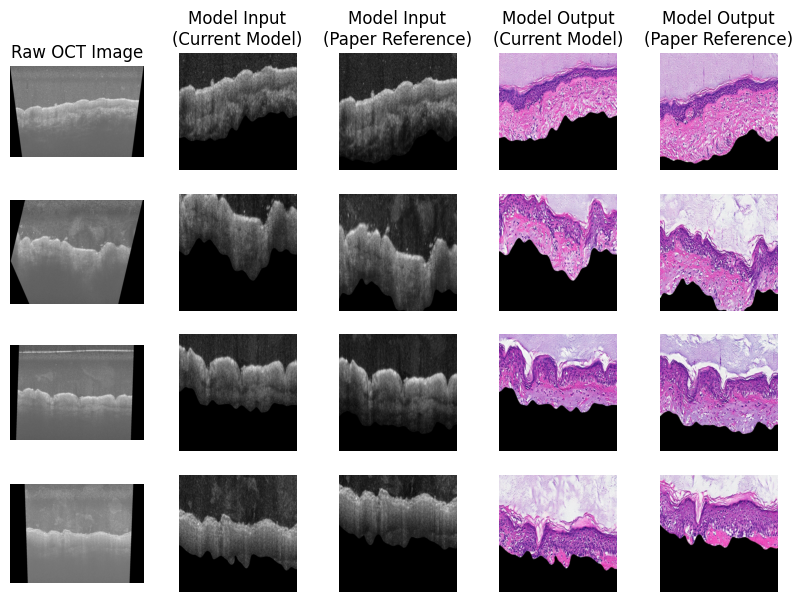

In [9]:
# Set up the environment
STEP_SIZE = 0
# Create container for output images
model_virtual_histology_images = []
model_o2h_inputs = []

for i,raw_dataset_path_oct_image_path in enumerate(raw_dataset_path_oct_image_paths):
  # Load image
  input_oct_image = cv2.imread(raw_dataset_path_oct_image_path)
  x0,z0,width,height = crop_coords(input_oct_image)

  # Crop using a default "in the middle" cropper
  cropped = crop(input_oct_image, width, height, x0, z0)
  # if(len(cropped.shape)>2):
  #   cropped = cropped[:,:,0]
  # Run Inference
  model_virtual_histology_image, _, o2h_input = oct2hist.run_network(cropped)
  model_virtual_histology_images.append(model_virtual_histology_image)
  model_o2h_inputs.append(o2h_input)

# Present results
display_images(raw_dataset_path_oct_image_paths, model_o2h_inputs,
    model_virtual_histology_images, preprocessed_oct_image_paths)